In [39]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)   
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [40]:
with open("data/Data_120294_2023-03-29.csv", "r") as f:
    d = pd.read_csv(f)

d.head()

/tmp/ipykernel_5577/2003393883.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(f)


,wl_org,cod_wl,cod_ostxt_wl,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,bmi_tcr,education,ecmo_tcr,iabp_tcr,inhaled_no,inotropes_tcr,vad_device_ty_tcr,vad_brand1_tcr,vad_brand2_tcr,vad_tah_tcr,func_stat_tcr,tcr_dgn,diab,dial_ty_tcr,cereb_vasc,malig_tcr,malig_ty_tcr,most_rcnt_creat,tot_serum_album,sud_death,impl_defibril,hemo_sys_tcr,hemo_pa_dia_tcr,hemo_pa_mn_tcr,hemo_pcw_tcr,hemo_co_tcr,cig_use,tcr_dur_abstain,prior_card_surg_tcr,histry_cig_old,sternotomy_tcr,ssdmf_death_date,days_stat1,days_stat1a,days_stat2,days_stat1b,days_stata4,days_stata5,days_stata2,days_stata3,days_stata1,days_stata6,init_stat,init_creat,rem_cd,dayswait_chron,end_stat,init_age,life_sup_tcr,activate_date,death_date,end_date,init_date,ethnicity,ethcat,pt_code,init_hgt_cm_calc,init_wgt_kg_calc,init_bmi_calc,end_hgt_cm_calc,end_wgt_kg_calc,end_bmi_calc,composite_death_date,ventilator_tcr,lvad_at_listing,lvad_while_listed,rvad_at_listing,rvad_while_listed,work_income_tcr,academic_prg_tcr,academic_level_tcr,exercise_o2,academic_level_trr,academic_prg_trr,func_stat_trr,med_cond_trr,ecmo_trr,work_income_trr,cognitive_dev_trr,motor_dev_trr,measurement_date_trr,pge_trr,creat_trr,dial_after_list,fev1_trr,fvc_trr,hemo_co_trr,hemo_pa_dia_trr,hemo_pa_mn_trr,hemo_pcw_trr,hemo_sys_trr,iabp_trr,infect_iv_drug_trr,inotropes_trr,inotrop_vaso_co_trr,inotrop_vaso_dia_trr,inotrop_vaso_mn_trr,inotrop_vaso_pcw_trr,inotrop_vaso_sys_trr,pco2_trr,steroid,tbili,transfusions,vad_device_ty_trr,prior_card_surg_type_trr,prior_card_surg_type_ostxt_trr,cmv_status,cod,cod_ostxt,gstatus,gtime,lastfuno,ptime,px_stat,func_stat_trf,amis,bmis,drmis,hlamis,pramr,prapk,pramr_cl1,pramr_cl2,prapk_cl1,prapk_cl2,hist_cocaine_don,age_don,ethcat_don,abo_don,alcohol_heavy_don,gender_don,cod_ostxt_don,bun_don,creat_don,sgot_don,sgpt_don,tbili_don,hypertens_dur_don,cancer_oth_ostxt_don,contin_cig_don,contin_cocaine_don,contin_oth_drug_don,diet_don,diuretics_don,diabdur_don,hist_hypertens_don,hist_cancer_don,hist_insulin_dep_don,hist_diabetes_don,diabetes_don,hist_oth_drug_don,insulin_don,hgt_cm_don_calc,wgt_kg_don_calc,bmi_don_calc,px_stat_date,tx_date,discharge_date,tx_type,abo_mat,age,dial_prior_tx,ischtime,grf_fail_cause,grf_fail_date,grf_stat,age_group,hgt_cm_calc,wgt_kg_calc,bmi_calc,distance,vad_tah_trr,tx_year,referral_date,pco2_don,pulm_cath_don,map_init_don,map_post_don,cvp_cath_init_don,cvp_cath_post_don,cvp_cath_old_don,pcwp_init_don,pcwp_post_don,svr_init_don,svr_post_don,syst_pa_cath_init_don,syst_pa_cath_post_don,systolic_pa_cath_old_don,diast_pa_cath_init_don,diast_pa_cath_post_don,diastolic_pa_cath_old_don,cardiac_output_cath_init_don,cardiac_output_cath_post_don,cardiac_output_cath_old_don,card_idx_init_don,card_idx_post_don,broncho_lt_don,broncho_rt_don,chest_xray_don,ph_don,hematocrit_don,abn_valves_don,abn_lvh_don,abn_congen_don,wall_abn_seg_don,wall_abn_glob_don,data_transplant,data_waitlist,alg_ind,alg_maint,cyclosporin_ind,cyclosporin_maint,okt4_ind,okt4_maint,cytoxan_ind,cytoxan_maint,methotrexate_ind,methotrexate_maint,brequinarsodium_ind,brequinarsodium_maint,mizoribine_ind,mizoribine_maint,atgam_ind,atgam_maint,nratgnrats_ind,nratgnrats_maint,okt3_ind,okt3_maint,xomazymecd5_ind,xomazymecd5_maint,dab486il2_ind,dab486il2_maint,antilfa1_ind,antilfa1_maint,antiicam1_ind,antiicam1_maint,il1receptorantagonist_ind,il1receptorantagonist_maint,antiil6_ind,antiil6_maint,antitnf_ind,antitnf_maint,solubleil1receptor_ind,solubleil1receptor_maint,aldesleukin_ind,aldesleukin_maint,t10b9_ind,t10b9_maint,sandimmune_ind,sandimmune_maint,deoxyspergualin_ind,deoxyspergualin_maint,neoral_ind,neoral_maint,sangcya_ind,sangcya_maint,thymoglobulin_ind,thymoglobulin_maint,zenapax_ind,zenapax_maint,simulect_ind,simulect_maint,gengraf_ind,gengraf_maint,zortress_ind,zortress_maint,eon_ind,eon_maint,myfortic_ind,myfortic_maint,genericcyclosporin_ind,genericcyclosporin_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,campath_ind,campath_maint,fty720_in

# Column categorization

In [41]:
print(d.education.dtype)
print(d.education.unique())

float64
[ nan   6.   5.   4.   3.   2. 996. 998.   1.]


There seems to exists columns that appear numeric but are actually categoric. We need to categorize all columns into numeric or categoric values in able to normalize and impute values properly.

In the provided documentation XLS file, numeric columns do not have a "SAS ANALYSIS FORMAT". The "SAS FORMAT" columns also gives information about how the data is formatted. Specially, some data is formatted as dates and datetimes, and need to be handled separately. Let's use this information to categorize the columns.

In [42]:
# fetch data from excel file
with open("data/Documentation.xls", "rb") as f:
    docs = pd.read_excel(f, sheet_name=None, header=None)
docs[list(docs.keys())[0]].head()

,0,1,2
0,Worksheet Tab Name,Description of Contents,Relative File (s)
1,File Formats,Explanation of the data file formats within folders provided on the disc,ALL
2,MAIN DOCUMENTATION,Descriptions for individual files with hyperlinks to data field documentation,ALL
3,Formats (Lookup Values),Provides locations for SAS formats and lookup values for variables,ALL
4,Additional HLA,Data dictionary for HLA data (all organ types),All Organs


In [43]:
def is_data_sheet(docs, sheet):
    if "SAS ANALYSIS FORMAT" in docs[sheet].values[1] \
    and "FORMAT".lower() not in sheet.lower():
        return True
    return False

def find_column_index(docs, sheet, column_name):
    return list(docs[sheet].values[1]).index(column_name)

discovered_columns = set()
numerical_columns = set()
categorical_columns = set()
date_columns = set()
text_columns = set()
drug_columns = set()
unknown_type_columns = set()

for sheet in docs:
    if is_data_sheet(docs, sheet):
        sas_index = find_column_index(docs, sheet, "SAS ANALYSIS FORMAT")
        format_index = find_column_index(docs, sheet, "SAS FORMAT")
        type_index = find_column_index(docs, sheet, "DATA TYPE")

        for row in docs[sheet].values[2:]:
            cname = row[0].lower()
            if cname not in discovered_columns:
                discovered_columns.add(cname)

                csas = str(row[sas_index]).upper()
                ctype = str(row[type_index]).upper()
                cformat = str(row[format_index]).upper()

                if "ostxt" in cname:
                    text_columns.add(cname)
                elif cname.endswith("_ind") or cname.endswith("_maint"):
                    drug_columns.add(cname)
                elif ctype == "NUM":
                    if "MMDDYY" in cformat or "MMDDYY" in csas:
                        date_columns.add(cname)
                    elif csas == "NAN":
                        numerical_columns.add(cname)
                    else:
                        categorical_columns.add(cname)
                elif ctype == "CHAR":
                    categorical_columns.add(cname)
                elif ctype == "DATE":
                    date_columns.add(cname)
                else:
                    unknown_type_columns.add(cname)


print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Date columns", date_columns)
print("String columns:", text_columns)
print("Unknown type columns:", unknown_type_columns)

Numerical columns: {'ethnicity_don', 'micro_fat_li_don', 'mcsdwithouthemoast', 'inosysbloodpressure', 'c_peptide', 'malig_denovo_tumor_6_dx_date', 'malig_don_rel_1_dx_date', 'hba1c_pa_tcr', 'wgt_kg', 'peripheral_rim2', 'hrsevfailcreatininedt', 'extinomuldobutamine', 'ki_creat_postop', 'high_pco2_ph', 'max_mismatch_ab', 'high_creat_dt', 'val_dt_malig', 'ventilator_tcr', 'high_pco2_pco2', 'max_expanded_mismatch_dr', 'doncrit_max_peak_inr', 'heparin_begin_dt', 'wgt_kg_don_calc', 'consent_attorney', 'tx_year', 'mcsdcardiacindexdt', 'skin_melanoma_donor', 'vasodilators_begin_dt', 'malig_denovo_tumor_5_dx_date', 'syst_pa_cath_post_don', 'hlamis', 'gstatus_pa', 'hba1c', 'pulm_inf_don', 'po2', 'mcsdwithrhfmilrinonedt', 'length_left_lung', 'malig_denovo_tumor_21_dx_date', 'mcsdwithrhfdopaminedt', 'malig_don_rel_19_dx_date', 'inhaled_no', 'currthermetolazone', 'max_mismatch_adr', 'max_iexpanded_mismatch_ab', 'hrsevfailsodium', 'grf_fail_dt', 'arginine_begin_dt', 'val_dt_trf', 'days_stata6', 'ast

Let's investigate the columns with unknown type.

In [44]:
for column in unknown_type_columns:
    if column in d.columns:
        print(column, d[column].dtype, d[column].unique())

None of these columns are in the dataset, so we are going to ignore them.

Let's explore how well the documentation describes the data set.

In [45]:

col_union = set.union(numerical_columns, categorical_columns, date_columns, text_columns, unknown_type_columns)
print("Number columns in the documentation:", len(col_union))

print("Number columns in dataset:", len(d.columns))

intersect = col_union & set(d.columns)
print("Number shared columns:", len(intersect))

# check which columns are not described in the documentation
non_described_columns = set(d.columns) - intersect
print("Number undocumented:", len(non_described_columns))
print("Undocumented columns:", non_described_columns)


Number columns in the documentation: 2763
Number columns in dataset: 320
Number shared columns: 222
Number undocumented: 98
Undocumented columns: {'dab486il2_ind', 'solubleil1receptor_maint', 'sangcya_ind', 'cellcept_ind', 'antilfa1_maint', 'rapamune_maint', 'brequinarsodium_ind', 'genericmyfortic_maint', 'envarsusxr_maint', 'neoral_maint', 'antitnf_maint', 'generictacrolimus_maint', 'nulojix_maint', 'zortress_maint', 'fty720_maint', '_merge', 'atgam_maint', 'oth_drug_ostxt1', 'genericsirolimus_ind', 'oth_drug_maint1', 'methotrexate_maint', 'imuran_ind', 'neoral_ind', 't10b9_maint', 'sandimmune_maint', 'aldesleukin_ind', 'alg_maint', 'envarsusxr_ind', 'cellcept_maint', 'dab486il2_maint', 'fty720_ind', 'mizoribine_ind', 'il1receptorantagonist_ind', 'aldesleukin_maint', 'gengraf_maint', 'sangcya_maint', 'okt3_ind', 'cyclosporin_ind', 'alg_ind', 'antiicam1_ind', 'campath_maint', 'antiil6_maint', 'campath_ind', 'oth_drug_ind1', 'brequinarsodium_maint', 'oth_drug_maint2', 'imuran_maint', 'c

Let's investigate the types of these columns.

In [46]:
for col in non_described_columns:
    # print unique values and counts of each column
    print(d[col].value_counts())

1.00000    10
0.00000     2
Name: dab486il2_ind, dtype: int64
0.00000    7
Name: solubleil1receptor_maint, dtype: int64
1.00000    32
0.00000    21
Name: sangcya_ind, dtype: int64
0.00000    33356
1.00000     2755
Name: cellcept_ind, dtype: int64
0.00000    6
Name: antilfa1_maint, dtype: int64
1.00000    1025
0.00000      92
Name: rapamune_maint, dtype: int64
1.00000    7
0.00000    2
Name: brequinarsodium_ind, dtype: int64
1.00000    291
Name: genericmyfortic_maint, dtype: int64
1.00000    88
Name: envarsusxr_maint, dtype: int64
1.00000    14116
0.00000      329
Name: neoral_maint, dtype: int64
0.00000    7
Name: antitnf_maint, dtype: int64
1.00000    12531
Name: generictacrolimus_maint, dtype: int64
1.00000    13
Name: nulojix_maint, dtype: int64
1.00000    240
0.00000     31
Name: zortress_maint, dtype: int64
Series([], Name: fty720_maint, dtype: int64)
Matched (3)        77410
Master only (1)    42854
Name: _merge, dtype: int64
0.00000    4842
1.00000     430
Name: atgam_maint, dty

Most of these columns are drug related or categorical. Let's categorize these similarly to before.

In [47]:
for col in non_described_columns:
    if col.endswith("_ind") or col.endswith("_maint"):
        drug_columns.add(col)
    elif "ostxt" in col:
        text_columns.add(col)
    else:
        categorical_columns.add(col)
unknown_type_columns = []

Let's investigate if any categoric columns have too many unique values.

In [48]:
# sort columns by number of unique values
categoric_sorted_unique = d[list(categorical_columns & set(d.columns))].nunique().sort_values(ascending=False)
print(categoric_sorted_unique)

cod                         76
cod_wl                      63
malig_ty_tcr                56
thoracic_dgn                56
tcr_dgn                     42
prior_card_surg_type_trr    27
func_stat_trr               25
func_stat_tcr               25
func_stat_trf               25
rem_cd                      18
end_stat                    11
init_stat                   11
abo_don                      9
abo                          9
tcr_dur_abstain              9
ethcat                       8
broncho_rt_don               8
ethcat_don                   8
education                    8
vad_tah_trr                  8
vad_tah_tcr                  8
broncho_lt_don               8
chest_xray_don               7
academic_level_trr           6
hist_diabetes_don            6
vad_device_ty_tcr            6
diab                         6
vad_device_ty_trr            6
dial_ty_tcr                  5
academic_prg_trr             5
academic_prg_tcr             5
cognitive_dev_trr            5
motor_de

Let's similarly investigate if any numeric columns have too few unique values.

In [49]:
numeric_sorted_unique = d[list(numerical_columns & set(d.columns))].nunique().sort_values(ascending=True)
print(numeric_sorted_unique)

init_creat                           0
rvad_at_listing                      1
lvad_while_listed                    1
lvad_at_listing                      1
pco2_trr                             1
rvad_while_listed                    1
iabp_tcr                             2
inotropes_trr                        2
pge_trr                              2
ecmo_tcr                             2
inotropes_tcr                        2
inhaled_no                           2
gstatus                              2
fev1_trr                             2
ecmo_trr                             2
fvc_trr                              2
ventilator_tcr                       2
iabp_trr                             2
amis                                 3
bmis                                 3
drmis                                3
exercise_o2                          4
sternotomy_tcr                       4
hlamis                               7
num_prev_tx                         10
vad_brand2_tcr           

Consulting with the documentation descriptions, some of these columns were misidentified, and should be categorical.

In [50]:
misidentified_columns = set([
    'init_creat',
    'lvad_at_listing',
    'lvad_while_listed',
    'rvad_at_listing',
    'rvad_while_listed',
    'iabp_tcr',
    'iabp_trr',
    'ecmo_tcr',
    'ecmo_trr',
    'inotropes_tcr',
    'inotropes_trr',
    'inhaled_no',
    'gstatus',
    'pge_trr',
    'ventilator_tcr',
    'amis',
    'bmis',
    'drmis',
    'vad_brand1_tcr',
    'vad_brand2_tcr'
])

#exercise_o2?

categorical_columns = categorical_columns | misidentified_columns
numerical_columns = numerical_columns - misidentified_columns

Let's exclude variables not in the dataset.

In [51]:
numerical_columns = list(numerical_columns & set(d.columns))
categorical_columns = list(categorical_columns & set(d.columns))
date_columns = list(date_columns & set(d.columns))
drug_columns = list(drug_columns & set(d.columns))
text_columns = list(text_columns & set(d.columns))

In [52]:
print("Columns in the dataset:\n")
print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))
print("Number text columns:", len(text_columns))

Columns in the dataset:

Number numeric columns: 91
Number categorical columns: 119
Number date columns: 12
Number drug columns: 91
Number text columns: 7


That's all the categorization done.

Let's additionally convert the date columns to comparable timestamps.

In [53]:
for col in date_columns:
    d[col] = pd.to_datetime(d[col], format="%d%b%Y")

# Removal of unwanted data

We want to remove all data of people under the age of 18.

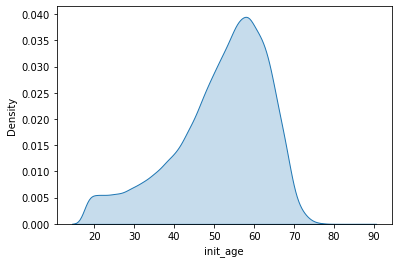

In [54]:
d = d[d.init_age >= 18]

# plot distribution of age
sns.kdeplot(d.init_age, fill=True)
plt.show()

Furthermore, we need to somehow merge entries belonging to the same patient.

One way to handle this is to just drop all rows of patients with more than one record in the waitlist. However, this might be a bit crude if there are many patients with multiple records.

Proportion of patients with more than one record: 0.07628644895324749
0    12314
1     2917
2       84
3       13
Name: num_prev_tx, dtype: int64
0     87734
1       925
2        53
3         8
5         3
6         2
10        2
4         2
9         1
7         1
Name: num_prev_tx, dtype: int64


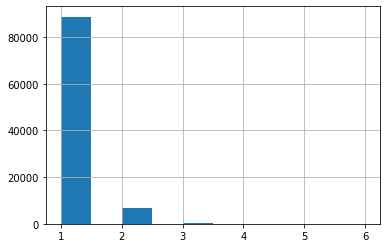

In [55]:
rcount = d.groupby("pt_code").wl_org.count()
rcount.hist()

gt1 = rcount[rcount > 1]

# print proportion of patients with at least 2 records
print("Proportion of patients with more than one record:", len(gt1) / d.pt_code.nunique())

# of those with more than one record, print the value counts for "num_prev_tx"
print(d[d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())
# num_prev_tx for those with only one record
print(d[~d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())

There are a significant amount of patients with multiple records.

A different approach could be to keep the most recent record for each patient, which is what we will try.

In [56]:
d.sort_values(by=['pt_code', 'num_prev_tx', 'init_date'], inplace=True)
d.drop_duplicates(subset=['pt_code', 'num_prev_tx'], keep='last', inplace=True)

There is a large amount of possible outcomes for each patient, detailed in the column rem_cd. Most of these outcomes have barely any patients assigned to them. We will filter the data set to only include the most common outcomes.

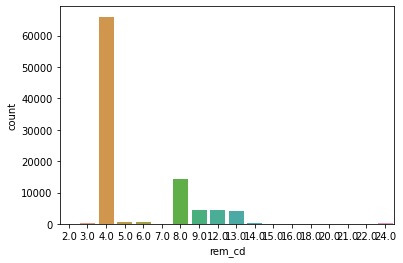

In [57]:
sns.countplot(x="rem_cd", data=d)
plt.show()

Let's remove all outcomes except the most common: [4,8,9,12,13]

In [58]:
d = d[d.rem_cd.isin([4,8,9,12,13])]

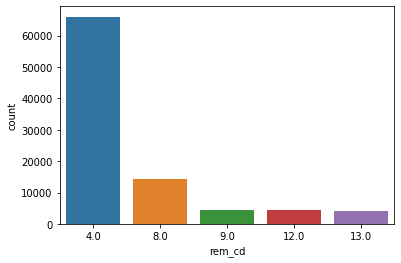

In [59]:
sns.countplot(x="rem_cd", data=d)
plt.show()

# Removal of outliers

Before imputation and normalization, outliers need to be removed.

In [63]:
# replace outliers of numerical columns with NaN
lower = d.quantile(0.0005, numeric_only=True)
upper = d.quantile(0.9995, numeric_only=True)
d2 = d.copy()

d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns].lt(upper)) & (d2[numerical_columns].gt(lower))]
d, d2 = d2, d

Here's an example of how removing outliers improves the usability of values. This is the distribution plot of the column "bmi_tcr" before and after removing outliers.

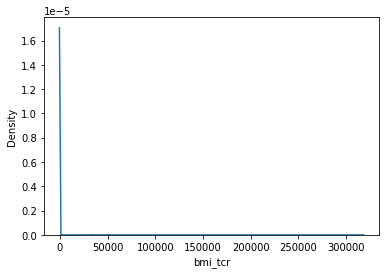

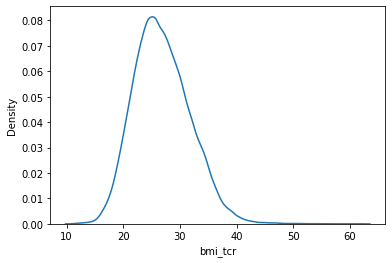

In [64]:
col = "bmi_tcr"

sns.kdeplot(d2[col].dropna())
plt.show()

sns.kdeplot(d[col].dropna())
plt.show()


# Selection of candidate columns

Variables are selected as deemed approprate by one of our supervisors.

In [65]:
sheet = pd.read_excel("data/VariableNames_v3.xlsx", sheet_name="Sheet1")
inclusion = dict(zip(sheet.iloc[:, 0], sheet.iloc[:, 2]))

selected_vars = [var for var in inclusion if inclusion[var] == "X"]
selected_vars.remove("init_creat") # only contains missing values

print("Selected variables:", selected_vars)
print("Number variables:", len(selected_vars))

Selected variables: ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'init_stat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr']
Number variables: 34


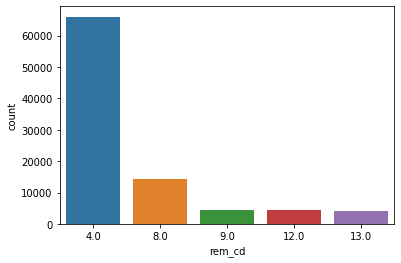

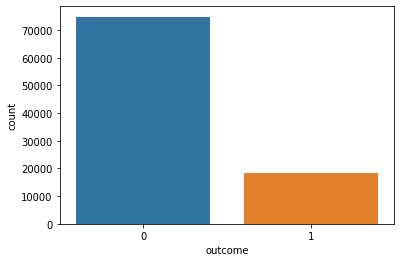

In [66]:
# 0 if transplant
# 1 if deceased
# 2 if removed for other reason
d["outcome"] = d.apply(
    lambda row: 
        1 if row.rem_cd in [8,13] # dies waiting
        else 0, axis=1) # lives

# print distribution plot of rem_cd
sns.countplot(x="rem_cd", data=d)
plt.show()

# print distribution plot of outcomes
sns.countplot(x="outcome", data=d)
plt.show()

In [67]:
# print percentage of each outcome
print(d.outcome.value_counts(normalize=True))

0   0.80266
1   0.19734
Name: outcome, dtype: float64


In [68]:
all_selected = selected_vars + ["outcome"]
d = d[all_selected]
selset = set(selected_vars)
numerical_columns = list(set(numerical_columns) & selset)
categorical_columns = list(set(categorical_columns) & selset)
date_columns = list(set(date_columns) & selset)
drug_columns = list(set(drug_columns) & selset)

print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))

Number numeric columns: 8
Number categorical columns: 26
Number date columns: 0
Number drug columns: 0


# Imputation

Let's add "missing value" columns.

In [69]:
# add missing indicator to all columns with missing values
for col in numerical_columns:
    if d[col].isna().any():
        d[col + "_missing"] = d[col].isna().astype(int)

# add missing category for each categorical column
for col in categorical_columns:
    d[col].fillna("missing", inplace=True)

Finally, let's impute the missing values.

In [70]:
# impute numerical columns with mean
d[numerical_columns] = d[numerical_columns].fillna(d[numerical_columns].mean())
# TODO: impute with randomness

# Normalization and encoding

Now, let's normalize numerical values.

In [71]:
from sklearn.preprocessing import StandardScaler

# standardize numerical columns
scaler = StandardScaler()
d[numerical_columns] = scaler.fit_transform(d[numerical_columns])

Let's also encode categorical columns using One-Hot encoding.

In [72]:
# select categorical columns with more/less than 2 unique values
catgt2 = list(d[categorical_columns].nunique()[d[categorical_columns].nunique() > 2].index)
catlt2 = list(d[categorical_columns].nunique()[d[categorical_columns].nunique() <= 2].index)

# one hot encode
d = pd.get_dummies(d, columns=catgt2)
d = pd.get_dummies(d, columns=catlt2, drop_first=True) # drop redundant column

In [73]:
d.head()

,wgt_kg_tcr,hgt_cm_tcr,most_rcnt_creat,tot_serum_album,hemo_co_tcr,init_age,init_hgt_cm_calc,init_wgt_kg_calc,outcome,most_rcnt_creat_missing,init_hgt_cm_calc_missing,tot_serum_album_missing,init_age_missing,wgt_kg_tcr_missing,hemo_co_tcr_missing,init_wgt_kg_calc_missing,hgt_cm_tcr_missing,icu_N,icu_Y,icu_missing,abo_A,abo_A1,abo_A1B,abo_A2,abo_A2B,abo_AB,abo_B,abo_O,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_6.0,education_996.0,education_998.0,education_missing,init_stat_2010.0,init_stat_2020.0,init_stat_2030.0,init_stat_2090.0,init_stat_2110.0,init_stat_2120.0,init_stat_2130.0,init_stat_2140.0,init_stat_2150.0,init_stat_2160.0,init_stat_2999.0,init_stat_missing,cig_use_N,cig_use_Y,cig_use_missing,vas_N,vas_Y,vas_missing,inotropic_N,inotropic_Y,inotropic_missing,prior_card_surg_tcr_N,prior_card_surg_tcr_U,prior_card_surg_tcr_Y,prior_card_surg_tcr_missing,diab_1.0,diab_2.0,diab_3.0,diab_4.0,diab_5.0,diab_998.0,diab_missing,cereb_vasc_N,cereb_vasc_U,cereb_vasc_Y,cereb_vasc_missing,malig_tcr_N,malig_tcr_U,malig_tcr_Y,malig_tcr_missing,dial_ty_tcr_1.0,dial_ty_tcr_2.0,dial_ty_tcr_3.0,dial_ty_tcr_998.0,dial_ty_tcr_999.0,dial_ty_tcr_missing,academic_level_tcr_1.0,academic_level_tcr_2.0,academic_level_tcr_3.0,academic_level_tcr_996.0,academic_level_tcr_998.0,academic_level_tcr_missing,thoracic_dgn_2,thoracic_dgn_14,thoracic_dgn_100,thoracic_dgn_999,thoracic_dgn_1000,thoracic_dgn_1001,thoracic_dgn_1002,thoracic_dgn_1003,thoracic_dgn_1004,thoracic_dgn_1005,thoracic_dgn_1006,thoracic_dgn_1007,thoracic_dgn_1049,thoracic_dgn_1050,thoracic_dgn_1051,thoracic_dgn_1052,thoracic_dgn_1053,thoracic_dgn_1054,thoracic_dgn_1099,thoracic_dgn_1100,thoracic_dgn_1101,thoracic_dgn_1102,thoracic_dgn_1103,thoracic_dgn_1104,thoracic_dgn_1105,thoracic_dgn_1106,thoracic_dgn_1199,thoracic_dgn_1200,thoracic_dgn_1201,thoracic_dgn_1202,thoracic_dgn_1203,thoracic_dgn_1204,thoracic_dgn_1205,thoracic_dgn_1206,thoracic_dgn_1207,thoracic_dgn_1208,thoracic_dgn_1209,thoracic_dgn_1497,thoracic_dgn_1498,thoracic_dgn_1500,thoracic_dgn_1501,thoracic_dgn_1549,thoracic_dgn_1550,thoracic_dgn_1551,thoracic_dgn_1552,thoracic_dgn_1600,thoracic_dgn_1601,thoracic_dgn_1602,thoracic_dgn_1604,thoracic_dgn_1605,thoracic_dgn_1606,thoracic_dgn_1607,thoracic_dgn_1609,thoracic_dgn_1998,thoracic_dgn_1999,onvent_N,onvent_Y,onvent_missing,tah_N,tah_Y,tah_missing,work_income_tcr_N,work_income_tcr_U,work_income_tcr_Y,work_income_tcr_missing,func_stat_tcr_1.0,func_stat_tcr_2.0,func_stat_tcr_3.0,func_stat_tcr_996.0,func_stat_tcr_998.0,func_stat_tcr_2010.0,func_stat_tcr_2020.0,func_stat_tcr_2030.0,func_stat_tcr_2040.0,func_stat_tcr_2050.0,func_stat_tcr_2060.0,func_stat_tcr_2070.0,func_stat_tcr_2080.0,func_stat_tcr_2090.0,func_stat_tcr_2100.0,func_stat_tcr_missing,lvad_at_listing_missing,ethnicity_1,ventilator_tcr_1,rvad_at_listing_missing,ecmo_tcr_1,inotropes_tcr_1,iabp_tcr_1,gender_M
33597,0.07623,-0.00000,0.27702,-1.11609,0.00000,1.38784,0.00000,0.07534,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
27162,0.35977,0.93181,-0.00000,0.00000,0.00000,-0.49664,0.93104,0.36005,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
19096,0.51401,0.93181,-0.00000,0.00000,-0.75168,-1.43889,0.93104,0.51493,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [74]:
print("Number columns after one-hot encoding:", len(d.columns))

Number columns after one-hot encoding: 178


# Simple Logistic Regression Model

In [75]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d.drop("outcome", axis=1), d.outcome, test_size=0.2, random_state=1337)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     15018
           1       0.67      0.40      0.50      3628

    accuracy                           0.85     18646
   macro avg       0.77      0.68      0.71     18646
weighted avg       0.83      0.85      0.83     18646



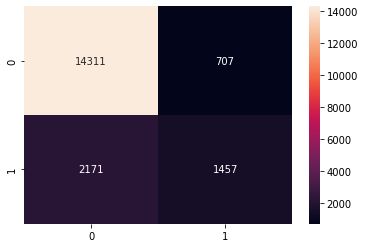

In [76]:
# Simple logistic regression model test
from sklearn.linear_model import LogisticRegression

# train model
model = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [77]:
# print weights ordered by scale
weights = pd.DataFrame({"feature": X_train.columns, "weight": model.coef_[0]})
weights["abs_weight"] = weights.weight.abs()
weights = weights.sort_values("abs_weight", ascending=False)
print(weights)

                         feature   weight  abs_weight
152      work_income_tcr_missing  4.52730     4.52730
151            work_income_tcr_Y -2.78911     2.78911
149            work_income_tcr_N -2.46796     2.46796
85      academic_level_tcr_996.0  2.26467     2.26467
168        func_stat_tcr_missing  1.95517     1.95517
60   prior_card_surg_tcr_missing -1.83060     1.83060
87    academic_level_tcr_missing  1.58107     1.58107
50               cig_use_missing -1.31821     1.31821
167         func_stat_tcr_2100.0 -1.21406     1.21406
84        academic_level_tcr_3.0 -1.19967     1.19967
86      academic_level_tcr_998.0 -0.95626     0.95626
113            thoracic_dgn_1106 -0.88058     0.88058
82        academic_level_tcr_1.0 -0.86311     0.86311
83        academic_level_tcr_2.0 -0.85751     0.85751
139            thoracic_dgn_1607 -0.85665     0.85665
112            thoracic_dgn_1105  0.83898     0.83898
102            thoracic_dgn_1051  0.81445     0.81445
111            thoracic_dgn_

# 2 * 60 Neural network

In [ ]:
# 2 * 60 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

m260 = Sequential([
    Dense(60, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(60, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

m260.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

early_stopping_monitor = EarlyStopping(patience=5)

history = m260.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

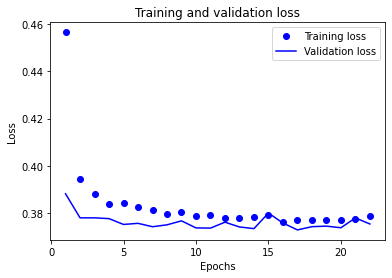

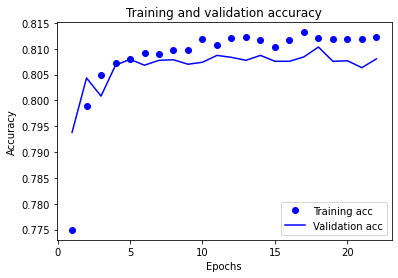

In [90]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

412/412 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.95      0.88     10077
           1       0.68      0.36      0.47      3097

    accuracy                           0.81     13174
   macro avg       0.76      0.65      0.68     13174
weighted avg       0.79      0.81      0.79     13174



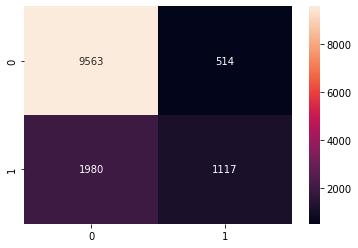

In [93]:
y_pred = np.round(m260.predict(X_test))

# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# 2*100 Neural Network

In [94]:
# 2 * 100 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

m200 = Sequential([
    Dense(100, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(100, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

m200.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

history = m200.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/100
1318/1318 [==============================] - 7s 5ms/step - loss: 0.4394 - accuracy: 0.7814 - val_loss: 0.3833 - val_accuracy: 0.7995
Epoch 2/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3908 - accuracy: 0.8033 - val_loss: 0.3805 - val_accuracy: 0.7995
Epoch 3/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3854 - accuracy: 0.8089 - val_loss: 0.3753 - val_accuracy: 0.8076
Epoch 4/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3827 - accuracy: 0.8084 - val_loss: 0.3757 - val_accuracy: 0.8048
Epoch 5/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3809 - accuracy: 0.8111 - val_loss: 0.3752 - val_accuracy: 0.8060
Epoch 6/100
1318/1318 [==============================] - 3s 3ms/step - loss: 0.3815 - accuracy: 0.8102 - val_loss: 0.3745 - val_accuracy: 0.8073
Epoch 7/100
1318/1318 [==============================] - 3s 3ms/step - loss: 0.3790 - accuracy: 0.8115 - val_loss: 0.3744 - val_ac

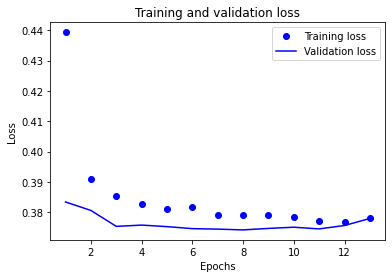

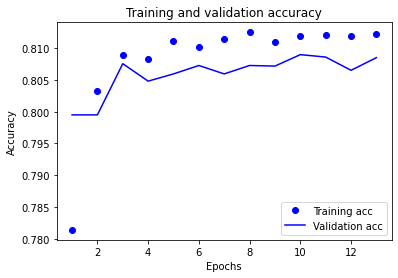

In [95]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

412/412 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     10077
           1       0.68      0.40      0.50      3097

    accuracy                           0.81     13174
   macro avg       0.76      0.67      0.70     13174
weighted avg       0.80      0.81      0.80     13174



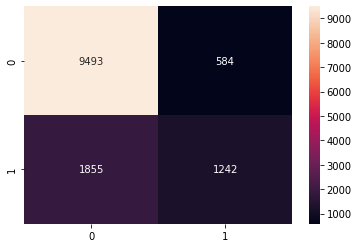

In [96]:
y_pred = np.round(m200.predict(X_test))

# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Forward Selection

In [346]:
# Perform forward feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

lr = LogisticRegression(solver="lbfgs", max_iter=1000)

# forward feature selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=50, direction="forward", scoring="f1_macro", n_jobs=-1)
sfs.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# print selected features
print("Selected features:", X_train.columns[sfs.get_support()])


Selected features: Index(['most_rcnt_creat', 'tot_serum_album', 'most_rcnt_creat_missing',
       'init_wgt_kg_calc_missing', 'cig_use_missing',
       'work_income_tcr_missing', 'rvad_at_listing_missing',
       'lvad_at_listing_missing', 'cereb_vasc_N', 'cereb_vasc_U',
       'cereb_vasc_Y', 'prior_card_surg_tcr_N', 'prior_card_surg_tcr_U',
       'prior_card_surg_tcr_Y', 'init_stat_2110.0', 'init_stat_2120.0',
       'init_stat_2140.0', 'init_stat_2150.0', 'dial_ty_tcr_3.0',
       'dial_ty_tcr_998.0', 'dial_ty_tcr_999.0', 'malig_tcr_N', 'malig_tcr_U',
       'malig_tcr_Y', 'thoracic_dgn_1201', 'thoracic_dgn_1202',
       'work_income_tcr_N', 'work_income_tcr_U', 'work_income_tcr_Y',
       'diab_998.0', 'func_stat_tcr_3.0', 'func_stat_tcr_996.0',
       'func_stat_tcr_2010.0', 'func_stat_tcr_2100.0',
       'academic_level_tcr_1.0', 'academic_level_tcr_2.0',
       'academic_level_tcr_3.0', 'academic_level_tcr_996.0',
       'academic_level_tcr_998.0', 'education_2.0', 'education_4

In [ ]:
import dill
dill.dump_session("post_forward_selection.db")
#